# Numerical Illustrations (Logisitic)


We will use a logistic model solved using logistic
 regression to illustrate the theoretical influence function bound proven in this paper. 

## Logisitic Design

We simulate a simple logistic model $y_i \sim \text{Binomial}(p_i)$, where  $p_i= \frac{1}{1+ \exp{(-(x_i^T\theta + \mu_i))}}$ for $n=[30, 1000]$. Each $x_i$ is iid standard normal random variables and and $\theta \in \mathbb{R}^9$ is fixed ahead of time. In order to introduce contaimination into the dataset, we let $\mu_i = (1-b_i)N(0,1)+b_iN(0,10)$ and $b_i\sim \text{Bernoulli}(.1)$.

We use a sample of $n = 50,000$ to simulate the population influence function.


In [3]:
# Simulate Data
import numpy as np
from math import sqrt

# Generate theta*
dim = 9
rng1 = np.random.RandomState(0)
beta_star = rng1.randn(dim)  # Random parameters
beta_star = beta_star / np.linalg.norm(beta_star)  # Make norm = 1

# Simulate training data
def sim_data(eps, n, rng):
    b = np.random.binomial(size=n, n=1, p=eps)
    # Normalize by dimension to small norm
    x = rng.normal(0, 1, size=(n, dim)) / dim  # (n, d)
    mu = (1-b) * rng.normal(0, 1, size=n) + b * \
        rng.normal(0, sqrt(10), size=n)  # (n,)
    prob = 1/(1+np.exp(-1*(np.matmul(x, beta_star) + mu)))
    y = rng.binomial(size=n, n=1, p=prob)
    return (x, y)

# Simulate contaminated point
def sim_contaminated(n, rng):
    x = rng.normal(0, 1, size=(n, dim)) / dim  # (n, d)
    mu = rng.normal(0, sqrt(10), size=n)  # (n,)
    prob = 1/(1+np.exp(-1*(np.matmul(x, beta_star) + mu)))
    y = np.array([rng.binomial(size=n, n=1, p=prob)])
    return (x, y)


# Empirical Influence Function for Logistic Regression

We will use the following closed form solution for the empirical influence function provided by Cook and Weisberg (1982).

$I_n(z)= -H_n(\theta_n)^{-1}(\psi(z,\theta_n))$

where $z=(x,y)$ and $\sigma(x,\theta) = \frac{1}{1+\exp{(-(x^T\theta))}}$

We define the following:

$H_n(\theta_n) = \frac1n\sum_{i=1}^n  x_ix_i^T*\sigma(x_i,\theta_n)(1-\sigma(x_i,\theta_n))$

$\psi(z,\theta_n = x^T(\sigma(x,\theta_n) - y)$

$\theta_n$ is calculated using ordinary least squares logistic regression

In [4]:
# Empirical Influence Function Parts (H_n)
# Need to use optimization algorithm to calculate IF
from scipy.linalg import block_diag
from numpy.linalg import inv
from sklearn import linear_model
import numpy as np

# Finding theta values using Logistic Regression
def logistic(x,y):
    clf = linear_model.LogisticRegression(penalty = 'none')
    clf.fit(x,y)
    return(clf)

def sigma(x,theta):
    return(1/(1+np.exp(-1*(np.dot(x,np.transpose(theta))))))

def emp_H_func(x,theta):
    return (1/x.shape[0])* np.dot(np.dot(np.transpose(x),(np.diag(sigma(x,theta)*(1-sigma(x,theta))))),x)

def psi_func(x_con,y_con,theta):
    return((np.dot(np.transpose(x_con), (sigma(x_con,theta)-y_con))))
    
def if_orth_emp(x_sim, y_sim,x_con, y_con):
    ols_theta = logistic(x_sim,y_sim).coef_
    psi = psi_func(x_con,y_con,ols_theta[0])
    H= emp_H_func(x_sim, ols_theta[0])
    H_inv_x = np.linalg.solve(H,psi)
    return(-1*H_inv_x, H)

## Run Simulations
We now calculate the difference between the empirical influence and population influence of $100$ simulated contamination datapoint using different training data sample sizes ($n = 29, 60, 121, 245, 495, 1000$). We consider the population influence function to be the empriical influence calculated at $n=50,000$.

In [5]:
# Runs n_sim number of simulations computing population and empirical IF on one contaminated point
def if_diff_sim(x_sim, y_sim,x_pop, y_pop, n, n_sim, rng):
    x_con_ls = []
    y_con_ls = []
    if_emp_ls = []
    if_pop_ls = []
    x_con_ls,y_con_ls = sim_contaminated(n_sim,rng)
    for i in range(n_sim):
        x_con = x_con_ls[i].reshape([1,len(x_con_ls[i])])
        y_con = y_con_ls[0][i]
        if_emp, H_emp = if_orth_emp(x_sim, y_sim, x_con, y_con)
        if_emp_ls.append(if_emp)
        # Using a large sample size to generate a "population" IF
        if_pop, H_pop = if_orth_emp(x_pop, y_pop,x_con,y_con)
        if_pop_ls.append(if_pop)
    return(x_con_ls, y_con_ls, if_emp_ls, if_pop_ls, H_pop)

In [6]:
# Run simulation
eps = .1
n_ls = list(np.logspace(np.log10(30),np.log10(1000),6).astype(int))
n_pop = 50000
n_sim = 100

mean_diff_abs_0 = []
sd_diff_abs_0 = []
mean_diff_abs_1 = []
sd_diff_abs_1 = []
mean_diff_abs_2 = []
sd_diff_abs_2 = []
mean_diff_abs_total = []
sd_diff_abs_total = []
n_samp = []

rng = np.random.RandomState(1)
rng2 = np.random.RandomState(2)

# Get population sample
y_pop = {}
while set(y_pop) != {0,1}:
    x_pop,y_pop = sim_data(eps, n_pop, rng2)

for n in n_ls:
    y_sim ={}
    # Make sure this is at least 1 of each category (in order to logistic regression)
    while set(y_sim) != {0,1}:
        x_sim,y_sim = sim_data(eps, n, rng)
    x_con_ls, y_con_ls, if_emp_ls, if_pop_ls, H_pop = if_diff_sim(x_sim, y_sim, x_pop, y_pop, n, n_sim, rng)
    diff_0 = []
    diff_1 = []
    diff_2 = []
    diff_abs_0 = []
    diff_abs_1 = []
    diff_abs_2 = []
    bound_val = []
    for i in range(len(if_emp_ls)):
        diff_abs_0.append(np.abs(if_emp_ls[i][0]-if_pop_ls[i][0]))
        diff_abs_1.append(np.abs(if_emp_ls[i][1]-if_pop_ls[i][1]))
        diff_abs_2.append(np.abs(if_emp_ls[i][2]-if_pop_ls[i][2]))
        diff_abs_total = np.abs(if_emp_ls[i]-if_pop_ls[i])
        bound_val.append(np.dot(np.matmul(diff_abs_total,H_pop),np.transpose(diff_abs_total)))
    sd_diff_abs_0.append(np.std(diff_abs_0))
    mean_diff_abs_0.append(np.mean(diff_abs_0))
    sd_diff_abs_1.append(np.std(diff_abs_1))
    mean_diff_abs_1.append(np.mean(diff_abs_1))
    sd_diff_abs_2.append(np.std(diff_abs_2))
    mean_diff_abs_2.append(np.mean(diff_abs_2))
    mean_diff_abs_total.append(np.mean(bound_val))
    sd_diff_abs_total.append(np.std(bound_val))
    n_samp.append(n)


## Calculate Statistical Bound (Theorem 1)
We calculate the bound from Theorem 1 without coefficients using the following equations. 

$\|I_n(z) - I(z)\|_{H_\star}^2 \leq \frac{p_\star^2}{\mu_\star n} log(\frac p\delta)^3$

where, $p_\star = \text{Tr}\bigg [H_\star^{-1/2}G_\star H_\star^{-1/2} \bigg] = \text{Tr}\bigg [H_\star^{-1}G_\star\bigg ]$

In [17]:
# Bound 
from scipy.linalg import sqrtm
import numpy as np
def stat_bound(p_star, mu_star,n,delta,p):
    return((p_star**2)/((mu_star)*pd.DataFrame(n))*np.log(p/delta)**3)

def p_star_func(H,x_con, y_con):
    H_inverse = np.linalg.inv(H) 
    # Find G_\star, gradient of a single point 
    grad = psi_func(x_con,y_con,ols_theta[0]) #n
    G_star = np.average(np.dot(grad,np.transpose(grad)))# 1
    return(np.trace(H_inverse*G_star))

import pandas as pd
n_ls = np.logspace(np.log10(30),np.log10(1000),6).astype(int)
eps = .1
n_pop = 50000
n_sim = 100
rng = np.random.RandomState(1)
rng2 = np.random.RandomState(2)
# Generate 100 contaminated points
x_con_ls,y_con_ls = sim_contaminated(n_sim,rng)
# Get population theta and H
ols_theta = logistic(x_pop,y_pop).coef_
H_pop = emp_H_func(x_pop, ols_theta[0])


delta = .05
p = 9
mu_star = np.min(np.linalg.eig(H_pop)[0])
n = list(np.logspace(np.log10(30),np.log10(1000),6).astype(int))[1:6]
stat_bound_ls=stat_bound(p,mu_star,n,delta,9)


## Graph Results

In [15]:
# Graphing Parameters
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams["lines.linewidth"] = 3
mpl.rcParams["xtick.labelsize"] = 12
mpl.rcParams["ytick.labelsize"] = 12
mpl.rcParams["ytick.labelsize"] = 12
mpl.rcParams["legend.fontsize"] = 18
mpl.rcParams["axes.titlesize"] = 18
mpl.rcParams["axes.labelsize"] = 18
mpl.rcParams['lines.markersize'] = 12
shape = ["o","X", "s","^", "P"]
line = ["solid", "dotted", "dashed", "dashdot","loosely dotted"]
COLORS = plt.rcParams['axes.prop_cycle'].by_key()['color']

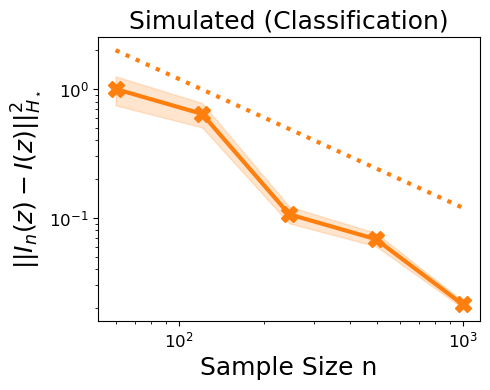

In [19]:
# Graph Results
import pandas as pd
bound_val_results = pd.DataFrame({"mean_diff_abs":mean_diff_abs_total, "n":n_samp,"sd_diff_abs":sd_diff_abs_total})

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5,4))
data = bound_val_results[1:6]
mean = np.abs(data['mean_diff_abs'])/np.max(np.abs(data['mean_diff_abs']))
sd = data['sd_diff_abs']/np.max(np.abs(data['sd_diff_abs']))
ax.plot(np.abs(data['n']),mean, color = COLORS[1], marker = shape[1], linestyle = line[0], markersize = 11, label = "Empirical")
ax.plot(np.abs(data['n']),2*stat_bound_ls[0]/np.max(stat_bound_ls[0]), color = COLORS[1], linestyle = line[1], label = "Bound")
ax.fill_between(np.abs(data['n']), mean-1.96*sd/np.sqrt(data['n']), mean+1.96*sd/np.sqrt(data['n']), alpha=0.2, color = COLORS[1])
ax.set_ylabel(r'$\|\| I_{n}(z) - I(z) \|\|_{H_\star}^2$')
ax.set_xlabel("Sample Size n")
ax.set_title('Simulated (Classification)')
ax.set_xscale("log")
ax.set_yscale("log")

plt.tight_layout()

plt.savefig("../../graphs/simulation_logistic_bound.pdf")
plt.savefig("../../graphs/simulation_logistic_bound.png")